# Reproduction of kaggle first place

Based on:

https://www.kaggle.com/c/seti-breakthrough-listen/discussion/266385

https://www.kaggle.com/code/ligtfeather/eca-nfnet-sam-opt-mixup-k-folds-w-b

First place solution architecture:

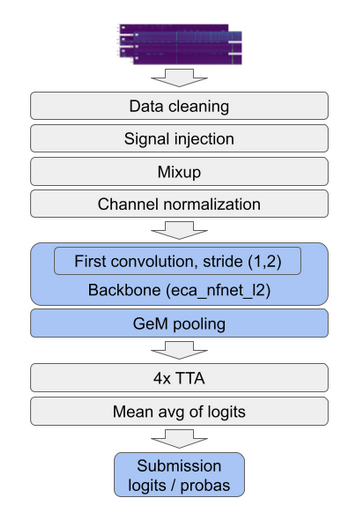

In [1]:
# !pip install timm
# !pip install albumentations
# !pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113
# !pip install torchsummary
# !pip install ray[tune]
# !pip install -U ray

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import random
from tqdm import tqdm
from collections import defaultdict
from datetime import datetime
import time
from itertools import chain

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
from torchsummary import summary
from sklearn.decomposition import NMF
from torch.cuda.amp import GradScaler
from torchvision import utils

import cv2

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score

import numpy as np
import pandas as pd
import timm
from adamp import AdamP

import albumentations
from albumentations.pytorch.transforms import ToTensorV2

import wandb
from matplotlib import pyplot as plt

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [3]:
global_config = {
    'num_workers': 4,
    'model': 'eca_nfnet_l0',
    'device': 'cuda',
    'image_size': 224,
    'input_channels': 1,
    'output_features': 1,
    'seed': 42,
    'target_size': 1,
    'T_max': 10,
    'min_lr': 1e-6,
    'lr': 1e-4,
    'weight_decay': 1e-6,
    'batch_size': 50,
    'epochs': 5,
    'num_folds': 1
}

In [4]:
def set_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seeds(seed=global_config['seed'])

# Data Loading

In [5]:
train_data_dir = r'D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Data\train'
labels_filepath = os.path.join(train_data_dir, '500_balanced_labels.npy')

with open(labels_filepath, 'rb') as f:
    initial_data = np.load(f, allow_pickle=True)
    
initial_data_df = pd.DataFrame(initial_data, columns=['id', 'target', 'image_filepath']).convert_dtypes()
initial_data_df['target'] = initial_data_df['target'].astype('int')

## Shuffle data

In [6]:
initial_data_df = initial_data_df.sample(frac=1).reset_index(drop=True)

In [7]:
initial_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              1000 non-null   string
 1   target          1000 non-null   int32 
 2   image_filepath  1000 non-null   string
dtypes: int32(1), string(2)
memory usage: 19.7 KB


Split the data into 70% train and 30% test:

In [8]:
data_split_mask = np.random.rand(len(initial_data_df)) < 0.7

train_df = initial_data_df[data_split_mask]
test_df = initial_data_df[~data_split_mask]

# Custom Dataset

In [9]:
def resize_image(image):
    return cv2.resize(image, dsize=(global_config['image_size'], global_config['image_size']), interpolation=cv2.INTER_CUBIC)


def plot_image(image):
    plt.figure(figsize = (20, 6))
    plt.imshow(image, aspect='auto')
    plt.show()


def normalise_image(image):
    image_min = image.min()
    image_max = image.max()

    return (image - image_min) / (image_max - image_min)


def get_decomposition_matrices(image):
    model = NMF(n_components=2, init='random', random_state=0)
    W = model.fit_transform(image + 100) # add 100 to ensure no negative values
    H = model.components_

    return (W, H)


def get_denoised_image(sample_images):
    combined_on_images = None
    combined_off_images = None
    combined_denoised_image = None

    for i in range(0, len(sample_images), 2):
        on_target_image = sample_images[i]
        off_target_image = sample_images[i+1]

        on_W, on_H = get_decomposition_matrices(on_target_image)
        off_W, off_H = get_decomposition_matrices(off_target_image)
        denoised_image = normalise_image(on_target_image - np.matmul(on_W, off_H))

        combined_on_images = on_target_image if combined_on_images is None else combined_on_images + on_target_image
        combined_off_images = off_target_image if combined_off_images is None else combined_off_images + off_target_image
        combined_denoised_image = denoised_image if combined_denoised_image is None else combined_denoised_image + denoised_image

    return combined_denoised_image

In [10]:
class CustomDataset(Dataset):
    def __init__(self, images_filepaths, targets, transform=None):
        self.images_filepaths = images_filepaths
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        images_filepath = self.images_filepaths[idx]
        images = np.load(images_filepath).astype(np.float32)
        image = get_denoised_image(images)

        if self.transform is not None:
            image = self.transform(image=image)['image']
        else:
            image = resize_image(image)
            image = image[np.newaxis,:,:]
            image = torch.from_numpy(image).float()

        label = torch.tensor(self.targets[idx]).float()

        return image, label

# Image Augmentation

In [11]:
def get_train_transforms():
    return albumentations.Compose(
        [
            albumentations.Resize(global_config['image_size'], global_config['image_size']),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.Rotate(limit=180, p=0.7),
            albumentations.RandomBrightnessContrast(brightness_limit=0.6, p=0.5),
            albumentations.CoarseDropout(max_holes=10, max_height=12, max_width=12, fill_value=0),
            albumentations.ShiftScaleRotate(shift_limit=0.25, scale_limit=0.1, rotate_limit=0),
            ToTensorV2(p=1.0),
        ]
    )

def get_valid_transforms():
    return albumentations.Compose(
        [
            albumentations.Resize(global_config['image_size'],global_config['image_size']),
            ToTensorV2(p=1.0)
        ]
    )

def get_test_transforms():
        return albumentations.Compose(
            [
                albumentations.Resize(global_config['image_size'], global_config['image_size']),
                ToTensorV2(p=1.0)
            ]
        )

# Train and Validation Dataloaders

In [12]:
def get_loaders(train_data, valid_data, batch_size):
    training_set = CustomDataset(
        images_filepaths=train_data['image_filepath'].values,
        targets=train_data['target'].values,
        transform = get_train_transforms()
    )

    validation_set = CustomDataset(
        images_filepaths=valid_data['image_filepath'].values,
        targets=valid_data['target'].values,
        transform = get_valid_transforms()
    )

    train_loader = DataLoader(
        training_set,
        batch_size = batch_size,
        shuffle=True,
        # num_workers=global_config['num_workers'],
        # sampler = sampler,
        pin_memory = True
    )

    valid_loader = DataLoader(
        validation_set,
        batch_size = batch_size,
        shuffle = False,
        # num_workers=global_config['num_workers'],
        pin_memory = True
    )

    return train_loader, valid_loader

# Model

In [13]:
# https://machinelearningknowledge.ai/pytorch-conv2d-explained-with-examples/#Example_of_PyTorch_Conv2D_in_CNN

class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc1 = nn.Linear(256, 1, bias=True)

        nn.init.xavier_uniform(self.fc1.weight)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(x.size(0), -1) # flatten for FC
        x = self.fc1(x)

        return x

## Criterion function

In [14]:
criterion = nn.BCEWithLogitsLoss().to(global_config['device'])

# Metric helper functions

In [15]:
def get_normalised_predictions(predictions):
    predictions_min = min(predictions)
    predictions_max = max(predictions)

    if predictions_min == predictions_max: # all predictions are the same
        return [0] * len(predictions)

    return [(x - predictions_min) / (predictions_max - predictions_min) for x in predictions]



def get_binary_classification(value):
    return 0 if value < 0.5 else 1



def get_binary_classifications(predictions):
    norm_predictions = np.array(get_normalised_predictions(predictions))
    binary_classification_func = np.vectorize(get_binary_classification)

    return binary_classification_func(norm_predictions)



def get_accuracy(predictions, labels):
    binary_classifications = get_binary_classifications(predictions)
    labels_array = labels.cpu().detach().numpy()
    correct_predictions = (binary_classifications == labels_array)
    correct_predictions_count = np.count_nonzero(correct_predictions)

    return np.mean(correct_predictions_count / len(predictions))



def get_roc_auc_score(output, target):
    try:
        return round(roc_auc_score(target, output), 10)
    except:
        return 0.5



def get_validation_loss_accuracy_rocauc(model, data_loader):
    loss = 0
    accuracy = 0
    roc_auc = 0

    model.eval()

    for x, y in data_loader:
        x, y = x.to(global_config['device']), y.to(global_config['device'])

        predictions = model(x)

        loss += criterion(predictions, y.unsqueeze(1)).item()
        accuracy += get_accuracy(predictions.cpu().detach().numpy(), y.unsqueeze(1))
        roc_auc += get_roc_auc_score(predictions, y.unsqueeze(1))


    num_samples = len(data_loader)

    return loss/num_samples, accuracy/num_samples, roc_auc/num_samples

In [16]:
model_name = 'cnn_from_scratch.pth'
current_datetime = datetime.now().strftime("%y-%m-%d_%H-%M-%S")
models_dir = os.path.join('models', current_datetime)

os.mkdir(models_dir)
os.mkdir(os.path.join(models_dir, 'raytune')) # directory for hyperparameter tuning results

In [17]:
# Declare global variables, so they can be accessed easily in various places

train_data = train_df.iloc[:400,:]
valid_data = train_df.iloc[400:,:]

train_losses = []
train_accuracies = []
train_roc_auc_scores = []

valid_losses = []
valid_accuracies = []
valid_roc_auc_scores = []

model = None

In [18]:
def train_and_validate(config):
    global train_data
    global valid_data

    global train_losses
    global train_accuracies
    global train_roc_auc_scores

    global valid_losses
    global valid_accuracies
    global valid_roc_auc_scores

    global model


    model = CustomModel()
    model = model.to(global_config['device'])
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    train_loader, valid_loader = get_loaders(train_df, valid_data, config['batch_size'])


    for epoch in range(1, global_config['epochs'] + 1):
        epoch_train_loss = 0
        epoch_train_acc = 0
        epoch_train_roc_auc = 0

        epoch_valid_loss = 0
        epoch_valid_acc = 0
        epoch_valid_roc_auc = 0

        for train_x, train_y in train_loader:
            # train_x is the batched image samples
            # train_y is the batched labels
            train_x, train_y = train_x.to(global_config['device']), train_y.to(global_config['device'])


            optimizer.zero_grad()


            # Training
            model.train()

            train_predictions = model(train_x)

            train_loss = criterion(train_predictions, train_y.unsqueeze(1))
            epoch_train_loss += train_loss.item()

            train_acc = get_accuracy(train_predictions.cpu().detach().numpy(), train_y.unsqueeze(1))
            epoch_train_acc += train_acc.item()

            epoch_train_roc_auc += get_roc_auc_score(train_predictions, train_y)


            # Validation
            valid_loss, valid_acc, valid_roc_auc = get_validation_loss_accuracy_rocauc(model, valid_loader)

            epoch_valid_loss += valid_loss
            epoch_valid_acc += valid_acc
            epoch_valid_roc_auc += valid_roc_auc


            # Back propagation
            train_loss.backward()

            # Update optimizer weights
            optimizer.step()

            # Report automatic hyperparameter tuning metric
            tune.report(loss=valid_loss, accuracy=valid_acc)

## Automatic hyperparameter tuning.

Based on:
  - https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html
  - https://docs.ray.io/en/master/_modules/ray/tune/tuner.html
  - https://debuggercafe.com/hyperparameter-tuning-with-pytorch-and-ray-tune/

In [19]:
def run_hyperparameter_search():
    # hyperparameter search space
    search_space = {
        'lr': tune.sample_from(lambda spec: 10 ** (-10 * np.random.rand())),
        'batch_size': tune.choice([4, 8, 16, 32, 64])
    }

    # scheduler to cut short poorly performing trials
    scheduler = ASHAScheduler(
        metric = 'loss',
        mode = 'min',
        max_t = global_config['epochs'],
        grace_period = 1,
        reduction_factor = 2
    )

    # Reporter for printing metrics
    reporter = CLIReporter(metric_columns = ['loss', 'accuracy', 'training_iteration'])

    # start tuning trial
    result = tune.run(
        train_and_validate,
        config=search_space,
        resources_per_trial={'cpu': 1, 'gpu': 2},
        num_samples=20,
        scheduler=scheduler,
        keep_checkpoints_num=1,
        local_dir=os.path.join(models_dir, 'raytune'),
        checkpoint_score_attr='min-validation_loss',
        progress_reporter=reporter
    )

    # get best trial hyperparameters
    best_trial = result.get_best_trial('loss', 'min', 'last')

    print(f'Best trial config: { best_trial.config }')
    print(f'Best trial final validation loss: { best_trial.last_result["loss"] }')
    print(f'Best trial final validation acc: { best_trial.last_result["accuracy"] }')


run_hyperparameter_search()

2022-09-02 00:57:57,760	INFO worker.py:1518 -- Started a local Ray instance.
2022-09-02 00:58:00,761	WARNING function_trainable.py:619 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


== Status ==
Current time: 2022-09-02 00:58:01 (running for 00:00:00.32)
Memory usage on this node: 10.2/16.0 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 1.0/8 CPUs, 2.0/2 GPUs, 0.0/3.85 GiB heap, 0.0/1.92 GiB objects
Result logdir: D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Prototype\models\22-09-02_00-57-54\raytune\train_and_validate_2022-09-02_00-58-00
Number of trials: 16/20 (15 PENDING, 1 RUNNING)
+--------------------------------+----------+-----------------+--------------+-------------+
| Trial name                     | status   | loc             |   batch_size |          lr |
|--------------------------------+----------+-----------------+--------------+-------------|
| train_and_validate_e8fb5_00000 | RUNNING  | 127.0.0.1:13152 |           64 | 0.0877714   |
| train_and_validate_e8fb5_00001 | PENDING  |                 |           16 | 9.42906e-07 |
| train_and_validate_e8fb5_0000

(train_and_validate pid=13152) C:\Users\adnan\AppData\Local\Temp\ipykernel_2008\1704196976.py:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


== Status ==
Current time: 2022-09-02 00:58:12 (running for 00:00:11.48)
Memory usage on this node: 11.5/16.0 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 1.0/8 CPUs, 2.0/2 GPUs, 0.0/3.85 GiB heap, 0.0/1.92 GiB objects
Result logdir: D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Prototype\models\22-09-02_00-57-54\raytune\train_and_validate_2022-09-02_00-58-00
Number of trials: 17/20 (16 PENDING, 1 RUNNING)
+--------------------------------+----------+-----------------+--------------+-------------+
| Trial name                     | status   | loc             |   batch_size |          lr |
|--------------------------------+----------+-----------------+--------------+-------------|
| train_and_validate_e8fb5_00000 | RUNNING  | 127.0.0.1:13152 |           64 | 0.0877714   |
| train_and_validate_e8fb5_00001 | PENDING  |                 |           16 | 9.42906e-07 |
| train_and_validate_e8fb5_0000

(train_and_validate pid=16648) C:\Users\adnan\AppData\Local\Temp\ipykernel_2008\1704196976.py:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


== Status ==
Current time: 2022-09-02 00:59:26 (running for 00:01:25.81)
Memory usage on this node: 11.9/16.0 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 4.000: -869.6453491210938 | Iter 2.000: -109.49160614013672 | Iter 1.000: -0.6929206609725952
Resources requested: 1.0/8 CPUs, 2.0/2 GPUs, 0.0/3.85 GiB heap, 0.0/1.92 GiB objects
Result logdir: D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Prototype\models\22-09-02_00-57-54\raytune\train_and_validate_2022-09-02_00-58-00
Number of trials: 18/20 (16 PENDING, 1 RUNNING, 1 TERMINATED)
+--------------------------------+------------+-----------------+--------------+-------------+---------+------------+----------------------+
| Trial name                     | status     | loc             |   batch_size |          lr |    loss |   accuracy |   training_iteration |
|--------------------------------+------------+-----------------+--------------+-------------+---------+------------+----------------------|
| train_and_val

(train_and_validate pid=14640) C:\Users\adnan\AppData\Local\Temp\ipykernel_2008\1704196976.py:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


== Status ==
Current time: 2022-09-02 00:59:47 (running for 00:01:46.84)
Memory usage on this node: 11.9/16.0 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 4.000: -869.6453491210938 | Iter 2.000: -109.49160614013672 | Iter 1.000: -0.69424088754152
Resources requested: 1.0/8 CPUs, 2.0/2 GPUs, 0.0/3.85 GiB heap, 0.0/1.92 GiB objects
Result logdir: D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Prototype\models\22-09-02_00-57-54\raytune\train_and_validate_2022-09-02_00-58-00
Number of trials: 19/20 (16 PENDING, 1 RUNNING, 2 TERMINATED)
+--------------------------------+------------+-----------------+--------------+-------------+------------+------------+----------------------+
| Trial name                     | status     | loc             |   batch_size |          lr |       loss |   accuracy |   training_iteration |
|--------------------------------+------------+-----------------+--------------+-------------+------------+------------+----------------------|
| train_

(train_and_validate pid=12020) C:\Users\adnan\AppData\Local\Temp\ipykernel_2008\1704196976.py:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


== Status ==
Current time: 2022-09-02 01:00:53 (running for 00:02:52.43)
Memory usage on this node: 12.0/16.0 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 4.000: -435.1688498429562 | Iter 2.000: -55.09229243523197 | Iter 1.000: -0.6938385649731285
Resources requested: 1.0/8 CPUs, 2.0/2 GPUs, 0.0/3.85 GiB heap, 0.0/1.92 GiB objects
Result logdir: D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Prototype\models\22-09-02_00-57-54\raytune\train_and_validate_2022-09-02_00-58-00
Number of trials: 20/20 (16 PENDING, 1 RUNNING, 3 TERMINATED)
+--------------------------------+------------+-----------------+--------------+-------------+------------+------------+----------------------+
| Trial name                     | status     | loc             |   batch_size |          lr |       loss |   accuracy |   training_iteration |
|--------------------------------+------------+-----------------+--------------+-------------+------------+------------+----------------------|
| train

(train_and_validate pid=7024) C:\Users\adnan\AppData\Local\Temp\ipykernel_2008\1704196976.py:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


== Status ==
Current time: 2022-09-02 01:01:25 (running for 00:03:24.69)
Memory usage on this node: 11.9/16.0 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 4.000: -435.1688498429562 | Iter 2.000: -109.49160614013672 | Iter 1.000: -0.6936226220507371
Resources requested: 1.0/8 CPUs, 2.0/2 GPUs, 0.0/3.85 GiB heap, 0.0/1.92 GiB objects
Result logdir: D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Prototype\models\22-09-02_00-57-54\raytune\train_and_validate_2022-09-02_00-58-00
Number of trials: 20/20 (15 PENDING, 1 RUNNING, 4 TERMINATED)
+--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                     | status     | loc             |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------|
| t

(train_and_validate pid=3732) C:\Users\adnan\AppData\Local\Temp\ipykernel_2008\1704196976.py:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


== Status ==
Current time: 2022-09-02 01:01:46 (running for 00:03:45.73)
Memory usage on this node: 11.4/16.0 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 4.000: -435.1688498429562 | Iter 2.000: -109.49160614013672 | Iter 1.000: -0.6938385649731285
Resources requested: 1.0/8 CPUs, 2.0/2 GPUs, 0.0/3.85 GiB heap, 0.0/1.92 GiB objects
Result logdir: D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Prototype\models\22-09-02_00-57-54\raytune\train_and_validate_2022-09-02_00-58-00
Number of trials: 20/20 (14 PENDING, 1 RUNNING, 5 TERMINATED)
+--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                     | status     | loc             |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------|
| t

(train_and_validate pid=13672) C:\Users\adnan\AppData\Local\Temp\ipykernel_2008\1704196976.py:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


== Status ==
Current time: 2022-09-02 01:03:02 (running for 00:05:01.59)
Memory usage on this node: 12.0/16.0 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 4.000: -36.59925842285156 | Iter 2.000: -66.92803115844727 | Iter 1.000: -0.6936226220507371
Resources requested: 1.0/8 CPUs, 2.0/2 GPUs, 0.0/3.85 GiB heap, 0.0/1.92 GiB objects
Result logdir: D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Prototype\models\22-09-02_00-57-54\raytune\train_and_validate_2022-09-02_00-58-00
Number of trials: 20/20 (13 PENDING, 1 RUNNING, 6 TERMINATED)
+--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                     | status     | loc             |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------|
| tr

(train_and_validate pid=16728) C:\Users\adnan\AppData\Local\Temp\ipykernel_2008\1704196976.py:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


== Status ==
Current time: 2022-09-02 01:03:25 (running for 00:05:24.99)
Memory usage on this node: 12.1/16.0 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 4.000: -36.59925842285156 | Iter 2.000: -66.92803115844727 | Iter 1.000: -0.6938385649731285
Resources requested: 1.0/8 CPUs, 2.0/2 GPUs, 0.0/3.85 GiB heap, 0.0/1.92 GiB objects
Result logdir: D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Prototype\models\22-09-02_00-57-54\raytune\train_and_validate_2022-09-02_00-58-00
Number of trials: 20/20 (12 PENDING, 1 RUNNING, 7 TERMINATED)
+--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                     | status     | loc             |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------|
| tr

(train_and_validate pid=12932) C:\Users\adnan\AppData\Local\Temp\ipykernel_2008\1704196976.py:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


== Status ==
Current time: 2022-09-02 01:03:48 (running for 00:05:47.60)
Memory usage on this node: 11.9/16.0 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 4.000: -36.59925842285156 | Iter 2.000: -66.92803115844727 | Iter 1.000: -0.6938584476813936
Resources requested: 1.0/8 CPUs, 2.0/2 GPUs, 0.0/3.85 GiB heap, 0.0/1.92 GiB objects
Result logdir: D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Prototype\models\22-09-02_00-57-54\raytune\train_and_validate_2022-09-02_00-58-00
Number of trials: 20/20 (11 PENDING, 1 RUNNING, 8 TERMINATED)
+--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                     | status     | loc             |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------|
| tr

(train_and_validate pid=2112) C:\Users\adnan\AppData\Local\Temp\ipykernel_2008\1704196976.py:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


== Status ==
Current time: 2022-09-02 01:04:54 (running for 00:06:54.07)
Memory usage on this node: 11.5/16.0 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 4.000: -18.645804493835097 | Iter 2.000: -24.364456176757812 | Iter 1.000: -0.6938385649731285
Resources requested: 1.0/8 CPUs, 2.0/2 GPUs, 0.0/3.85 GiB heap, 0.0/1.92 GiB objects
Result logdir: D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Prototype\models\22-09-02_00-57-54\raytune\train_and_validate_2022-09-02_00-58-00
Number of trials: 20/20 (10 PENDING, 1 RUNNING, 9 TERMINATED)
+--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                     | status     | loc             |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------|
| 

(train_and_validate pid=14476) C:\Users\adnan\AppData\Local\Temp\ipykernel_2008\1704196976.py:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


== Status ==
Current time: 2022-09-02 01:06:07 (running for 00:08:06.47)
Memory usage on this node: 11.9/16.0 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 4.000: -1.0333773136138915 | Iter 2.000: -12.683264958858489 | Iter 1.000: -0.6937128243948284
Resources requested: 1.0/8 CPUs, 2.0/2 GPUs, 0.0/3.85 GiB heap, 0.0/1.92 GiB objects
Result logdir: D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Prototype\models\22-09-02_00-57-54\raytune\train_and_validate_2022-09-02_00-58-00
Number of trials: 20/20 (9 PENDING, 1 RUNNING, 10 TERMINATED)
+--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                     | status     | loc             |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------|
|

(train_and_validate pid=12736) C:\Users\adnan\AppData\Local\Temp\ipykernel_2008\1704196976.py:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


== Status ==
Current time: 2022-09-02 01:07:12 (running for 00:09:12.01)
Memory usage on this node: 11.3/16.0 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 4.000: -0.8628639392162624 | Iter 2.000: -1.0020737409591676 | Iter 1.000: -0.6935870838165283
Resources requested: 1.0/8 CPUs, 2.0/2 GPUs, 0.0/3.85 GiB heap, 0.0/1.92 GiB objects
Result logdir: D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Prototype\models\22-09-02_00-57-54\raytune\train_and_validate_2022-09-02_00-58-00
Number of trials: 20/20 (8 PENDING, 1 RUNNING, 11 TERMINATED)
+--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                     | status     | loc             |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------|
|

(train_and_validate pid=9792) C:\Users\adnan\AppData\Local\Temp\ipykernel_2008\1704196976.py:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


== Status ==
Current time: 2022-09-02 01:07:36 (running for 00:09:35.22)
Memory usage on this node: 11.4/16.0 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 4.000: -0.8628639392162624 | Iter 2.000: -1.0020737409591676 | Iter 1.000: -0.6937128243948284
Resources requested: 1.0/8 CPUs, 2.0/2 GPUs, 0.0/3.85 GiB heap, 0.0/1.92 GiB objects
Result logdir: D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Prototype\models\22-09-02_00-57-54\raytune\train_and_validate_2022-09-02_00-58-00
Number of trials: 20/20 (7 PENDING, 1 RUNNING, 12 TERMINATED)
+--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                     | status     | loc             |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------|
|

(train_and_validate pid=16788) C:\Users\adnan\AppData\Local\Temp\ipykernel_2008\1704196976.py:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


== Status ==
Current time: 2022-09-02 01:07:59 (running for 00:09:58.29)
Memory usage on this node: 11.7/16.0 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 4.000: -0.8628639392162624 | Iter 2.000: -1.0020737409591676 | Iter 1.000: -0.6938385649731285
Resources requested: 1.0/8 CPUs, 2.0/2 GPUs, 0.0/3.85 GiB heap, 0.0/1.92 GiB objects
Result logdir: D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Prototype\models\22-09-02_00-57-54\raytune\train_and_validate_2022-09-02_00-58-00
Number of trials: 20/20 (6 PENDING, 1 RUNNING, 13 TERMINATED)
+--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                     | status     | loc             |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------|
|

(train_and_validate pid=15124) C:\Users\adnan\AppData\Local\Temp\ipykernel_2008\1704196976.py:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


== Status ==
Current time: 2022-09-02 01:08:20 (running for 00:10:19.41)
Memory usage on this node: 11.3/16.0 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 4.000: -0.8628639392162624 | Iter 2.000: -1.0020737409591676 | Iter 1.000: -0.6938584476813936
Resources requested: 1.0/8 CPUs, 2.0/2 GPUs, 0.0/3.85 GiB heap, 0.0/1.92 GiB objects
Result logdir: D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Prototype\models\22-09-02_00-57-54\raytune\train_and_validate_2022-09-02_00-58-00
Number of trials: 20/20 (5 PENDING, 1 RUNNING, 14 TERMINATED)
+--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                     | status     | loc             |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------|
|

(train_and_validate pid=16964) C:\Users\adnan\AppData\Local\Temp\ipykernel_2008\1704196976.py:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


== Status ==
Current time: 2022-09-02 01:09:41 (running for 00:11:40.60)
Memory usage on this node: 11.2/16.0 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 4.000: -0.6926337599754333 | Iter 2.000: -0.8475262356431861 | Iter 1.000: -0.6938385649731285
Resources requested: 1.0/8 CPUs, 2.0/2 GPUs, 0.0/3.85 GiB heap, 0.0/1.92 GiB objects
Result logdir: D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Prototype\models\22-09-02_00-57-54\raytune\train_and_validate_2022-09-02_00-58-00
Number of trials: 20/20 (4 PENDING, 1 RUNNING, 15 TERMINATED)
+--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                     | status     | loc             |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------|
|

(train_and_validate pid=2112) C:\Users\adnan\AppData\Local\Temp\ipykernel_2008\1704196976.py:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


== Status ==
Current time: 2022-09-02 01:10:17 (running for 00:12:16.44)
Memory usage on this node: 11.6/16.0 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 4.000: -0.6926337599754333 | Iter 2.000: -1.0020737409591676 | Iter 1.000: -0.6937128243948284
Resources requested: 1.0/8 CPUs, 2.0/2 GPUs, 0.0/3.85 GiB heap, 0.0/1.92 GiB objects
Result logdir: D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Prototype\models\22-09-02_00-57-54\raytune\train_and_validate_2022-09-02_00-58-00
Number of trials: 20/20 (3 PENDING, 1 RUNNING, 16 TERMINATED)
+--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                     | status     | loc             |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------|
|

(train_and_validate pid=16724) C:\Users\adnan\AppData\Local\Temp\ipykernel_2008\1704196976.py:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


== Status ==
Current time: 2022-09-02 01:10:38 (running for 00:12:37.54)
Memory usage on this node: 11.2/16.0 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 4.000: -0.6926337599754333 | Iter 2.000: -1.0020737409591676 | Iter 1.000: -0.6938385649731285
Resources requested: 1.0/8 CPUs, 2.0/2 GPUs, 0.0/3.85 GiB heap, 0.0/1.92 GiB objects
Result logdir: D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Prototype\models\22-09-02_00-57-54\raytune\train_and_validate_2022-09-02_00-58-00
Number of trials: 20/20 (2 PENDING, 1 RUNNING, 17 TERMINATED)
+--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                     | status     | loc             |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------|
|

(train_and_validate pid=16708) C:\Users\adnan\AppData\Local\Temp\ipykernel_2008\1704196976.py:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


== Status ==
Current time: 2022-09-02 01:11:14 (running for 00:13:13.94)
Memory usage on this node: 11.6/16.0 GiB
Using AsyncHyperBand: num_stopped=18
Bracket: Iter 4.000: -0.6926337599754333 | Iter 2.000: -2.395972263813019 | Iter 1.000: -0.6937128243948284
Resources requested: 1.0/8 CPUs, 2.0/2 GPUs, 0.0/3.85 GiB heap, 0.0/1.92 GiB objects
Result logdir: D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Prototype\models\22-09-02_00-57-54\raytune\train_and_validate_2022-09-02_00-58-00
Number of trials: 20/20 (1 PENDING, 1 RUNNING, 18 TERMINATED)
+--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                     | status     | loc             |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------|
| 

(train_and_validate pid=3912) C:\Users\adnan\AppData\Local\Temp\ipykernel_2008\1704196976.py:37: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


== Status ==
Current time: 2022-09-02 01:11:35 (running for 00:13:35.12)
Memory usage on this node: 11.2/16.0 GiB
Using AsyncHyperBand: num_stopped=19
Bracket: Iter 4.000: -0.6926337599754333 | Iter 2.000: -2.395972263813019 | Iter 1.000: -0.6938385649731285
Resources requested: 1.0/8 CPUs, 2.0/2 GPUs, 0.0/3.85 GiB heap, 0.0/1.92 GiB objects
Result logdir: D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Prototype\models\22-09-02_00-57-54\raytune\train_and_validate_2022-09-02_00-58-00
Number of trials: 20/20 (1 RUNNING, 19 TERMINATED)
+--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------+
| Trial name                     | status     | loc             |   batch_size |          lr |        loss |   accuracy |   training_iteration |
|--------------------------------+------------+-----------------+--------------+-------------+-------------+------------+----------------------|
| train_and_v

2022-09-02 01:12:26,576	INFO tune.py:758 -- Total run time: 865.81 seconds (865.60 seconds for the tuning loop).


Result for train_and_validate_e8fb5_00019:
  accuracy: 0.5135416666666667
  date: 2022-09-02_01-12-26
  done: true
  experiment_id: 67ce2c0e2a6f4288ba37117d0f2f6cfa
  hostname: DESKTOP-UV2VLMG
  iterations_since_restore: 4
  loss: 0.6936254262924194
  node_ip: 127.0.0.1
  pid: 3912
  time_since_restore: 55.51846408843994
  time_this_iter_s: 13.095250368118286
  time_total_s: 55.51846408843994
  timestamp: 1662077546
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: e8fb5_00019
  warmup_time: 0.004000425338745117
  
== Status ==
Current time: 2022-09-02 01:12:26 (running for 00:14:25.63)
Memory usage on this node: 11.5/16.0 GiB
Using AsyncHyperBand: num_stopped=20
Bracket: Iter 4.000: -0.6931295931339263 | Iter 2.000: -1.0020737409591676 | Iter 1.000: -0.6937128243948284
Resources requested: 0/8 CPUs, 0/2 GPUs, 0.0/3.85 GiB heap, 0.0/1.92 GiB objects
Result logdir: D:\UoL\Level 6\CM3070 - Final Project\SETI Signal Detection\Prototype\models\22-09-02_00-57-54\raytune\train

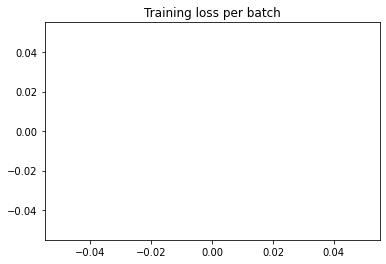

In [20]:
# training loss
plt.title('Training loss per batch')
plt.plot(train_losses[1:])

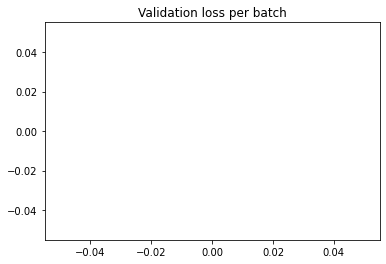

In [21]:
# validation loss
plt.title('Validation loss per batch')
plt.plot(valid_losses[1:])

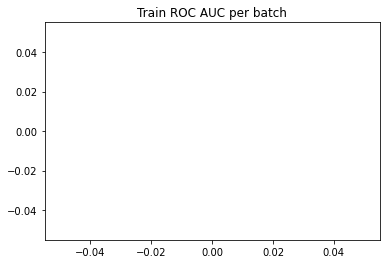

In [22]:
# train roc auc
plt.title('Train ROC AUC per batch')
plt.plot(train_roc_auc_scores[1:])

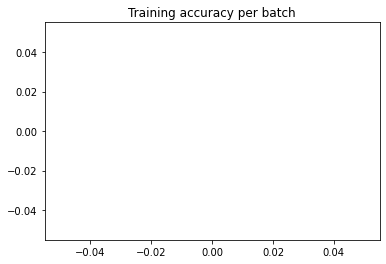

In [23]:
# training accuracy
plt.title('Training accuracy per batch')
plt.plot(train_accuracies[1:])

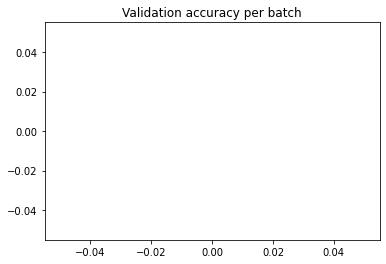

In [24]:
# validation accuracy
plt.title('Validation accuracy per batch')
plt.plot(valid_accuracies)

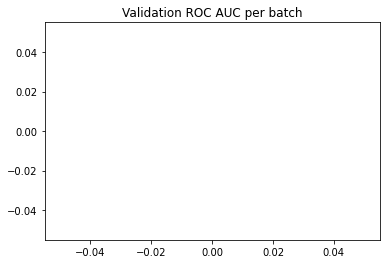

In [25]:
# validation roc auc
plt.title('Validation ROC AUC per batch')
plt.plot(valid_roc_auc_scores)

# Analysis

## Run best performing model against test set

In [26]:
def get_test_loader(test_data):
    test_set = CustomDataset(
        images_filepaths=test_data['image_filepath'].values,
        targets=test_data['target'].values,
        # transform=get_valid_transforms()
    )

    return DataLoader(
        test_set,
        batch_size=global_config['batch_size'],
        shuffle=False,
        # num_workers=global_config['num_workers'],
        pin_memory=True
    )

In [27]:
test_targets = []
test_outputs = []

model.cuda()
model.eval()

for X_batch, y_batch in get_test_loader(test_df):
    X_batch, y_batch = X_batch.to(global_config['device']), y_batch.to(global_config['device'])

    y_pred = model(X_batch)

    test_targets.append(y_batch)
    test_outputs.extend([t.item() for t in y_pred])

AttributeError: 'NoneType' object has no attribute 'cuda'

Prediction values are in a range:

In [ ]:
plt.plot(test_outputs)

Normalise between 0, 1 and use 0.5 as threshold for binary classification:

In [ ]:
normalised_predictions = get_normalised_predictions(test_outputs)

In [ ]:
plt.plot(normalised_predictions)

Map to binary classifications using sigmoid function:

In [ ]:
test_targets_float = [x.cpu().numpy() for x in test_targets]
test_targets_float = np.concatenate(test_targets_float, axis=0).tolist()
test_outputs_binary = [0 if x < 0.5 else 1.0 for x in normalised_predictions]

In [ ]:
test_results_df = pd.DataFrame([test_targets_float, test_outputs_binary])

test_results_df = test_results_df.transpose()
test_results_df.columns = ['label', 'prediction']

test_results_df

In [ ]:
pd.crosstab(test_results_df['prediction'], test_results_df['label'])

In [ ]:
print(classification_report(test_results_df['prediction'], test_results_df['label']))

# Visualise filters

In [ ]:
# https://stackoverflow.com/questions/55594969/how-to-visualise-filters-in-a-cnn-with-pytorch

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1):
        n,c,w,h = tensor.shape

        if allkernels: tensor = tensor.view(n*c, -1, w, h)
        elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

        rows = np.min((tensor.shape[0] // nrow + 1, 64))
        grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
        plt.figure( figsize=(nrow,rows) )
        plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [ ]:
model = CustomModel()
model.load_state_dict(torch.load(os.path.join(models_dir, model_name)))
model.eval()

In [ ]:
def plot_filter(kernel):
    # normalise between 0 and 1
    normalised_kernel = kernel - kernel.min()
    normalised_kernel = normalised_kernel / normalised_kernel.max()

    # make a grid of images
    filter = utils.make_grid(normalised_kernel, nrow = 12)

    # matplotlib uses (height x width x channels) format
    # pytorch uses (batch index x channel x height x width) format
    plt.imshow(filter.permute(1, 2, 0))

In [ ]:
kernel = model.layer1[0].weight.detach().clone()

print(kernel.size())
plot_filter(kernel)

In [ ]:
kernel = model.layer2[0].weight.detach().clone()

print(kernel.size())

# plot_filter(kernel[0][2])


for i in range(len(kernel)):
    plot_filter(kernel[i])
    # for j in range(len(kernel[i])):
    #     plot_filter(kernel[i][j])
    #     j += 1

    i += 1